In [1]:
import os

# if you want to use the GPU
#device = 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import cv2
import random
import pickle
import itertools

import matplotlib.pyplot as plt

import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

from PIL import Image
#import theano
from theano import config

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import load_model
import h5py

from IPython.display import display


# %% Imports
from pathlib import Path
import sys
root_dir = Path().resolve()
sys.path.append(str(root_dir / 'src'))

from recsys_common import *

np.random.seed(123) 

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\cwimm\appdata\local\programs\python\python36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


## Load the Data

In [19]:
X_train = pickle.load(open("X_train", "rb"))
y_train = pickle.load(open("y_train", "rb"))

X_val = pickle.load(open("X_val", "rb"))
y_val = pickle.load(open("y_val.pickle", "rb"))

## Padding

In [ ]:
# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences

X_train = pad_sequences(X_train, maxlen = maxlen, padding = 'post')
X_val = pad_sequences(X_val, maxlen = maxlen, padding = 'post')
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))

## Normalization

In [20]:
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)

## Creating CNN Models in Keras

In [8]:
epochs = 10
batch_size = 16
val_split = 0.20

In [9]:
np.random.seed(123)

NAME = "RECSYS-CNN-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

print(NAME)
            
model = Sequential()

# Input Layer
model.add(Conv2D(32, (3,3), input_shape = X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
            
# Conv. Layers

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
            
# Dense Layers
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.3))

#Output Layer
model.add(Dense(157))
model.add(Activation("softmax"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["accuracy"])

checkpointer = ModelCheckpoint(filepath='C:\\1Christoph\\Uni\\TU\\2. Semester\\Recommender Systems Team Project\\YYY\\CNN Best Model\\2Model{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5',monitor='val_acc', verbose=1, save_best_only=True)
            # fits the model on batches with real-time data augmentation:
model_fit = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[checkpointer])

model.save(f"RECSYS-CNN-2-Epochs-adam-CNN-{int(time.time())}.h5")

RECSYS-CNN-1563099147
Train on 784 samples, validate on 88 samples
Epoch 1/10
784/784 [==============================] - 68s 86ms/step - loss: 3.3406 - acc: 0.0599 - val_loss: 3.2777 - val_acc: 0.0682

Epoch 00001: val_acc improved from -inf to 0.06818, saving model to C:\1Christoph\Uni\TU\2. Semester\Recommender Systems Team Project\YYY\CNN Best Model\2Model01-3.28-0.07.h5
Epoch 2/10
784/784 [==============================] - 67s 85ms/step - loss: 3.1795 - acc: 0.0829 - val_loss: 3.1052 - val_acc: 0.0795

Epoch 00002: val_acc improved from 0.06818 to 0.07955, saving model to C:\1Christoph\Uni\TU\2. Semester\Recommender Systems Team Project\YYY\CNN Best Model\2Model02-3.11-0.08.h5
Epoch 3/10
784/784 [==============================] - 67s 85ms/step - loss: 3.0837 - acc: 0.0880 - val_loss: 3.0035 - val_acc: 0.0909

Epoch 00003: val_acc improved from 0.07955 to 0.09091, saving model to C:\1Christoph\Uni\TU\2. Semester\Recommender Systems Team Project\YYY\CNN Best Model\2Model03-3.00-0.09.

In [10]:
model1 = load_model('CNN Best Model\\2Model08-2.53-0.30.h5')

In [11]:
predictions = model1.predict_classes(X_val)
accuracy_score(y_val, predictions)

0.2967032967032967

### Plotting the Training Curve

In [12]:
hist = model_fit.history
hist.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

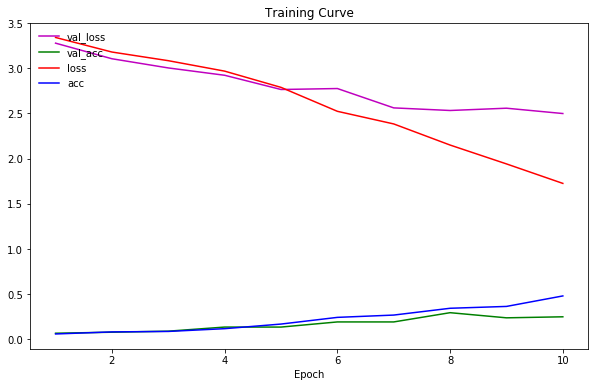

In [13]:
%matplotlib inline 

colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

### Model 2

In [ ]:
epochs = 10
batch_size = 16
val_split = 0.2

In [14]:
np.random.seed(123)

NAME = "RECSYS-CNN-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

print(NAME)
            
model = Sequential()

# Input Layer
model.add(Conv2D(32, (3,3), input_shape = X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
            
# Conv. Layers

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
            
# Dense Layers
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.3))

#Output Layer
model.add(Dense(157))
model.add(Activation("softmax"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["accuracy"])

checkpointer = ModelCheckpoint(filepath='C:\\1Christoph\\Uni\\TU\\2. Semester\\Recommender Systems Team Project\\YYY\\CNN Best Model\\2Model{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5',monitor='val_acc', verbose=1, save_best_only=True)
            # fits the model on batches with real-time data augmentation:
model_fit = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[checkpointer])

model.save(f"RECSYS-CNN-1-Epochs-adam-CNN-{int(time.time())}.h5")

RECSYS-CNN-1563101803
Train on 784 samples, validate on 88 samples
Epoch 1/10
784/784 [==============================] - 69s 88ms/step - loss: 3.4008 - acc: 0.0357 - val_loss: 3.3972 - val_acc: 0.0568

Epoch 00001: val_acc improved from -inf to 0.05682, saving model to C:\1Christoph\Uni\TU\2. Semester\Recommender Systems Team Project\YYY\CNN Best Model\2Model01-3.40-0.06.h5
Epoch 2/10
784/784 [==============================] - 66s 84ms/step - loss: 3.3930 - acc: 0.0459 - val_loss: 3.3916 - val_acc: 0.0568

Epoch 00002: val_acc did not improve from 0.05682
Epoch 3/10
784/784 [==============================] - 66s 84ms/step - loss: 3.3852 - acc: 0.0434 - val_loss: 3.3856 - val_acc: 0.0568

Epoch 00003: val_acc did not improve from 0.05682
Epoch 4/10
784/784 [==============================] - 62s 79ms/step - loss: 3.3789 - acc: 0.0485 - val_loss: 3.3809 - val_acc: 0.0795

Epoch 00004: val_acc improved from 0.05682 to 0.07955, saving model to C:\1Christoph\Uni\TU\2. Semester\Recommender Sy

In [15]:
model2 = load_model('CNN Best Model\\2Model10-3.31-0.10.h5')

In [16]:
predictions = model2.predict_classes(X_val)
accuracy_score(y_val, predictions)

0.10989010989010989

In [ ]:
### Plotting the Training Curve

In [17]:
hist = model_fit.history
hist.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

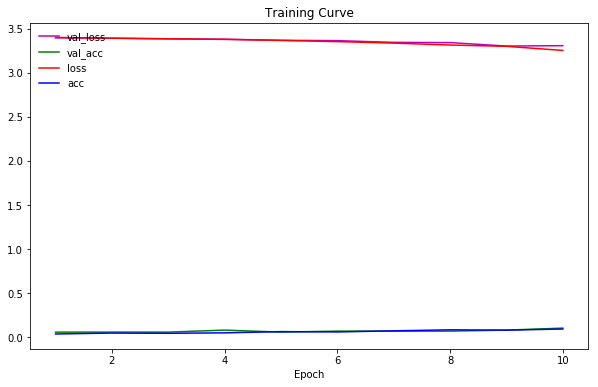

In [18]:
%matplotlib inline 

colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)